# 5.3 基于迁移学习技术来识别猫狗

## 采用段到段的模式从卷积基中提取特征，对应教材pp117-121

## 1 载模型
## 创建VGG16卷积基实例（即仅使用卷积层，而不使用全连接层作为分类器）

In [42]:
from keras.applications import VGG16

In [43]:
#创建VGG16实例，提前下载VGG16模型的h5文件，然后放置在C:\Users\Administrator\.keras\models
#include_top：是否包含全连接层
#weights：模型初始权重
conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (150,150,3))

### 通过函数summary回顾下卷积基的网络结构

In [44]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### vgg16的卷积核包含5部分：
### 第1-2部分：Conv2D x 2 + MaxPooling2D
### 第3-5部分：Conv2D x 3 + MaxPooling2D
### 卷积核的输出特征维度为 4 x 4 x 512, 我们需要在此基础上添加自定义的Dense层来实现分类器

## 2 理图形
## 对输入VGG16的图片进行预处理

In [45]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

### 设置训练集、验证集、测试集的图片目录

In [46]:
base_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog'
train_dir = os.path.join(base_dir,'train')
validation_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir, 'test')

In [47]:
train_dir

'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog\\train'

### 创建数据生成器实例

### 场景1：不使用数据增强技术

In [52]:
#实例化ImageDataGenerator，不使用数据增强技术
#datagen = ImageDataGenerator(rescale = 1./255)

### 场景2：使用数据增强技术

In [53]:
#使用数据增强技术
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')

## 3 特征明
## 将数据集输入模型1（卷积基），预测输出即为特征提取张量

### 定义特征提取函数
### 基于数据生成器将图像张量批量输入至卷积基，通过函数predict获取卷积基的特征张量
### 输入：提取图片样本目录；提取样本数
### 输出：返回VGG16卷积基输出的张量；样本对应的分类结果

In [54]:
#定义特征提取函数

batch_size = 20

#通过指定路径获取样本数进行特征提取
def extract_features(directory, sample_count):
    #初始化features,labels矩阵
    features_vgg16 = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    
    #生成器加载
    generator = datagen.flow_from_directory(directory,
                                           target_size = (150,150),
                                           batch_size = 20,
                                           class_mode = 'binary')
    i = 0
    for fs,ls in generator:
        vgg16_output = conv_base.predict(fs) 
        features_vgg16[i*batch_size : (i+1)*batch_size] = vgg16_output
        labels[i*batch_size : (i+1)*batch_size] = ls
        i+=1
        if i*batch_size >= sample_count:
            break
    
    return features_vgg16,labels
    

### 对训练集、验证集、测试集进行特征提取

In [55]:
#对训练集、验证集、测试集进行特征提取
train_features,train_labels = extract_features(train_dir,2000)
validation_features,validation_labels = extract_features(validation_dir,1000)
test_features,test_labels = extract_features(test_dir,1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_features.shape

## 4 重展平
## 展平特征提取张量(即n维变1维）

### 注意：VGG16特征提取后的形状为(samples, 4, 4, 512), 因此在输入到分类器之前需要先展平
### (样本数, 4, 4, 512) 四维张量 -----> (样本数, 4 x 4 x 512 = 8192)

In [56]:
trian_features_reshaped = np.reshape(train_features, (2000, 8192))
validation_features_reshaped = np.reshape(validation_features, (1000, 8192))
test_features_reshaped = np.reshape(test_features, (1000, 8192))

## 5 分类型
## 将展平后的张量输入到模型2（自定义分类器）并训练
### （1）无论分类设计成什么样，分类器的输入的张量尺寸要与卷积基的输出张量尺寸保持一致，这样才能串联起来
### （2）可参考5.2节中的全连接层进行设计，即2个dense层串联而成
### （3）猫狗识别的二分类问题，因此最后一个dense层一定要选择sigmoid作为激活函数
### （4）为防止过拟合，可使用dropout正则化技术

In [57]:
from keras import models
from keras import layers
from keras import optimizers

In [58]:
model_after_vgg16 = models.Sequential()
#与conv_base串接起来，故分类器的输入张量尺寸与卷积基的输出张量尺寸一致
model_after_vgg16.add(layers.Dense(256, activation = 'relu', input_dim = 4*4*512))
model_after_vgg16.add(layers.Dropout(0.5)) #降低过拟合
model_after_vgg16.add(layers.Dense(1, activation = 'sigmoid'))

### 编译模型

In [59]:
model_after_vgg16.compile(optimizer = optimizers.RMSprop(lr = 2e-5), loss = 'binary_crossentropy', metrics = ['acc'])

## 6 训练模型

In [60]:
#训练参数：
#-迭代次数
#-批量大小
#-验证集
import time
start = time.time()

history_model_after_vgg16 = model_after_vgg16.fit(trian_features_reshaped,train_labels, epochs = 30, batch_size =20, validation_data = (validation_features_reshaped, validation_labels))

end = time.time()
print("训练时间（s）：%d"%(end - start))

Epoch 1/30
100/100 [==============================] - 3s 29ms/step - loss: 0.6593 - acc: 0.6060 - val_loss: 0.5519 - val_acc: 0.7500
Epoch 2/30
100/100 [==============================] - 3s 28ms/step - loss: 0.5365 - acc: 0.7330 - val_loss: 0.4946 - val_acc: 0.7970
Epoch 3/30
100/100 [==============================] - 3s 28ms/step - loss: 0.4808 - acc: 0.7845 - val_loss: 0.4607 - val_acc: 0.7920
Epoch 4/30
100/100 [==============================] - 3s 28ms/step - loss: 0.4520 - acc: 0.7935 - val_loss: 0.4404 - val_acc: 0.8100
Epoch 5/30
100/100 [==============================] - 3s 28ms/step - loss: 0.4025 - acc: 0.8315 - val_loss: 0.4183 - val_acc: 0.8150
Epoch 6/30
100/100 [==============================] - 3s 29ms/step - loss: 0.3911 - acc: 0.8290 - val_loss: 0.4063 - val_acc: 0.8240
Epoch 7/30
100/100 [==============================] - 3s 28ms/step - loss: 0.3749 - acc: 0.8355 - val_loss: 0.3948 - val_acc: 0.8280
Epoch 8/30
100/100 [==============================] - 3s 29ms/step - 

### 基于段到段的特征特取模式，模型训练时间约为19s

In [61]:
#model_after_vgg16.save('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_1_convbase_classfication_without_data_augment.h5')
model_after_vgg16.save('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_1_convbase_classfication_with_data_augment.h5')

## 7 评估模型

### 7.1 评估验证集的loss和acc

In [62]:
import matplotlib.pyplot as plt

train_acc = history_model_after_vgg16.history['acc']
val_acc = history_model_after_vgg16.history['val_acc']
train_loss = history_model_after_vgg16.history['loss']
val_loss = history_model_after_vgg16.history['val_loss']

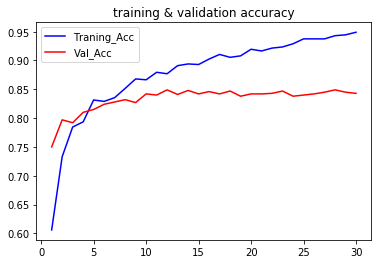

In [63]:
epochs = range(1,len(train_acc)+1)

plt.plot(epochs, train_acc, 'b', label = 'Traning_Acc')
plt.plot(epochs, val_acc, 'r', label = 'Val_Acc')
plt.title('training & validation accuracy')
plt.legend()
plt.show()

### 由上图可观察到，验证集在10轮以后的分类准确率趋近于极限，在第20轮出现最大值
### 分类准确率达到99%，通过迁移学习，我们将5.2节中完全自定义的深度网络分类准确提高了超过20%，模型达到完全可用状态

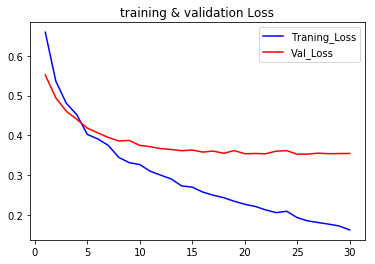

In [64]:
plt.plot(epochs, train_loss, 'b', label = 'Traning_Loss')
plt.plot(epochs, val_loss, 'r', label = 'Val_Loss')
plt.title('training & validation Loss')
plt.legend()
plt.show()

### 验证集在Loss的变化趋势与acc类似

### 7.2 评估部分测试照片

In [65]:
from keras.models import load_model
my_network = load_model('D:/2-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_1_convbase_classfication_with_data_augment.h5')

In [66]:
import numpy as np
def preprocess_img(img):
    x1 = image.img_to_array(img)
    x2 = x1 * 1./255
    x3 = np.expand_dims(x2, axis = 0)
    return x3

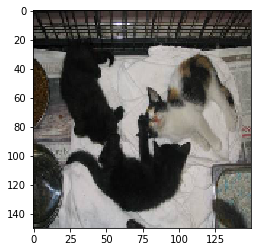

In [67]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/cats/cat.12436.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [68]:
extracted_features = conv_base.predict(preprocess_img(img2))
input_features = np.reshape(extracted_features, (1,8192))
pred = my_network.predict(input_features)
pred

array([[0.09281552]], dtype=float32)

#### 上述照片分类预测概率为X，即模型预测是X，分类正确or错误

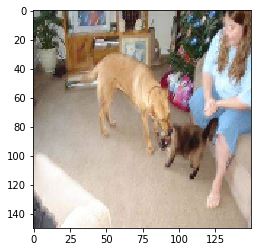

In [69]:
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12005.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [70]:
extracted_features = conv_base.predict(preprocess_img(img2))
input_features = np.reshape(extracted_features, (1,8192))
pred = my_network.predict(input_features)
pred

array([[0.7845351]], dtype=float32)

#### 上述照片分类预测概率为X，即模型预测是X，分类正确or错误

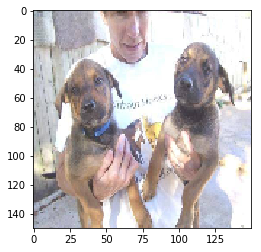

In [71]:
#指定非洲象图片存储路径
img_path2 = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/full_dataset_cat_dog/test/dogs/dog.12003.jpg'
#通过target_size 指定图片加载尺寸为224 x 224，以适配VGG16模型
img2 = image.load_img(img_path2, target_size = (150, 150))
plt.imshow(img2)

In [72]:
extracted_features = conv_base.predict(preprocess_img(img2))
input_features = np.reshape(extracted_features, (1,8192))
pred = my_network.predict(input_features)
pred

array([[0.9482561]], dtype=float32)

#### 上述照片分类预测概率为n，即模型预测为x，分类正确or错误

### 7.3 评估模型在测试集上表现

In [32]:
# from keras.models import load_model
# my_network = load_model('E:/0-AI读书学习笔记/0-python深度学习/0-model_repo/ch5_3_transfer_learning_1_convbase_classfication.h5')

In [73]:
import os
from keras.preprocessing import image

classes = ['cats','dogs']
files_name = []
test_true_labels = []
test_pred_labels = []
test_pred_probs = []

for c in classes:
    test_class_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/{}'.format(c)
    for f in os.listdir(test_class_dir):
        
        files_name.append(f)
        test_true_labels.append(f[0:3])
        
        img_path = os.path.join(test_class_dir, f)
        img = image.load_img(img_path, target_size = (150, 150))
        #预处理图片&提取卷积基特征
        extracted_features = conv_base.predict(preprocess_img(img))
        #展平张量
        input_features = np.reshape(extracted_features, (1,8192))
        #模型预测
        pred = my_network.predict(input_features)
        test_pred_probs.append(pred)
        
        pred_label = None
        if pred[0] > 0.5:
            pred_label = 'dog'
        else:
            pred_label = 'cat'
        test_pred_labels.append(pred_label)  

In [74]:
import pandas as pd
df = pd.DataFrame(data={'file':files_name, 'true_label':test_true_labels,  'pred_label':test_pred_labels, 'pred_prob':test_pred_probs})
pred_error_records = df[df['true_label'] != df['pred_label']].shape[0]
error_rate = float(pred_error_records)/float(1000)
error_rate

0.123

### 测试集上分类错误率为 x%

### 查看分类错误的猫图片

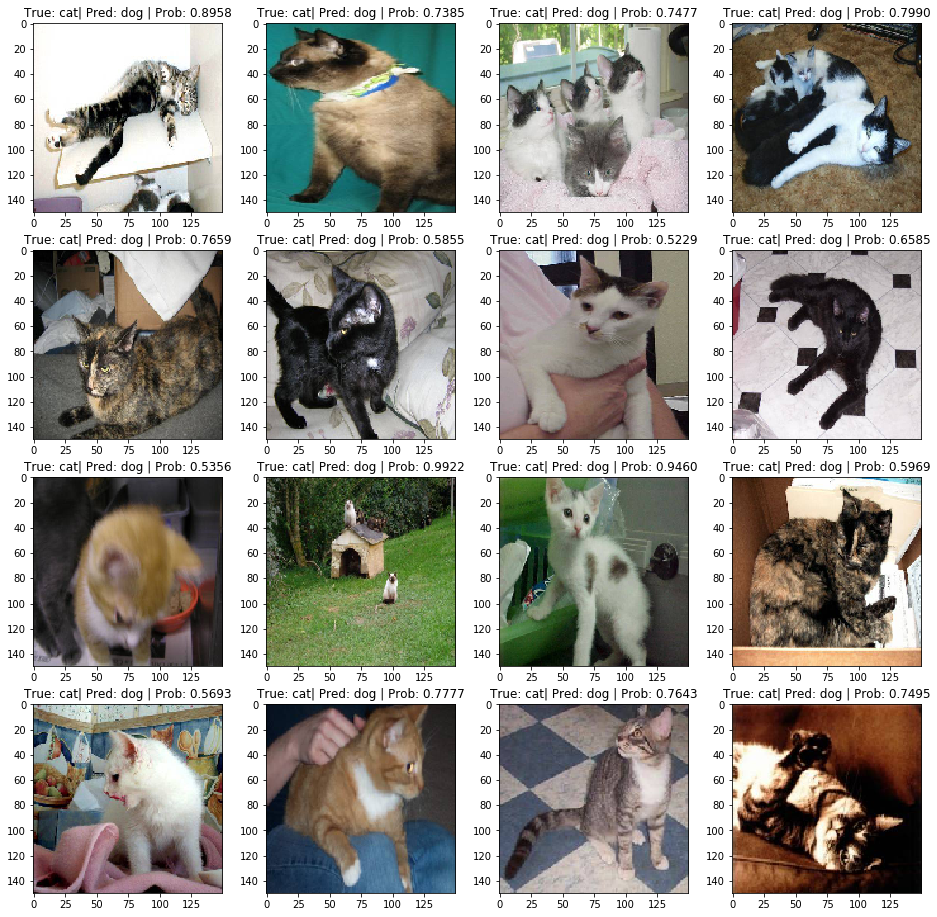

In [41]:
df_error = df[(df['true_label'] != df['pred_label']) & (df['true_label'] == 'cat')]

#对分类错误记录进行随机抽取，每次抽取16行记录，可以反复运行此段代码，随机查看分类错误图片
df_error_sample = df_error.sample(n=16, replace = False, axis = 0)
files_error = list(df_error_sample['file'])
true_labels_error =  list(df_error_sample['true_label'])
pred_labels_error =  list(df_error_sample['pred_label'])
pred_probs_error = list(df_error_sample['pred_prob'])


import matplotlib.pyplot as plt
n_rows= 4
n_cols= 4 

#16个分类错误记录用4x4图片排布展现出来
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

c = 0
for i in range(n_rows):
    for j in range(n_cols):
        img_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/cats/{}'.format(files_error[c])
        image_error = image.load_img(img_dir, target_size = (150,150))
        
        axs[i][j].imshow(image_error);
        axs[i][j].set_title('True: {}| Pred: {} | Prob: {:.4f}'.format(true_labels_error[c], pred_labels_error[c], pred_probs_error[c][0][0]));
        c+=1

### 查看分类错误的狗的图片

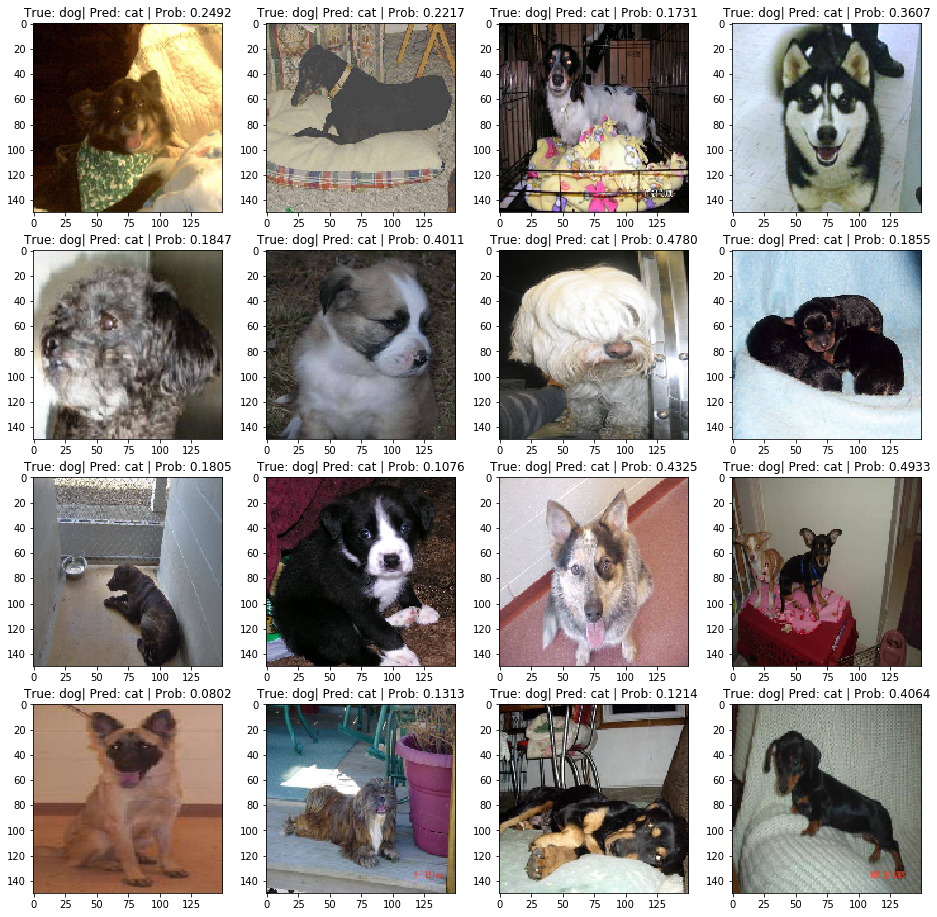

In [10]:
df_error = df[(df['true_label'] != df['pred_label']) & (df['true_label'] == 'dog')]
#对分类错误记录进行随机抽取，每次抽取16行记录，可以反复运行此段代码，随机查看分类错误图片
df_error_sample = df_error.sample(n=16, replace = False, axis = 0)
files_error = list(df_error_sample['file'])
true_labels_error =  list(df_error_sample['true_label'])
pred_labels_error =  list(df_error_sample['pred_label'])
pred_probs_error = list(df_error_sample['pred_prob'])


import matplotlib.pyplot as plt
n_rows= 4
n_cols= 4 

#16个分类错误记录用4x4图片排布展现出来
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4*n_rows))

c = 0
for i in range(n_rows):
    for j in range(n_cols):
        img_dir = 'D:/2-AI读书学习笔记/99-dataset-lib/cat_dog/small_dataset_cat_dog/test/dogs/{}'.format(files_error[c])
        image_error = image.load_img(img_dir, target_size = (150,150))
        
        axs[i][j].imshow(image_error);
        axs[i][j].set_title('True: {}| Pred: {} | Prob: {:.4f}'.format(true_labels_error[c], pred_labels_error[c], pred_probs_error[c][0][0]));
        c+=1